<a href="https://colab.research.google.com/github/ykitaguchi77/AdvancedPytorch_Colab/blob/master/Pytorch_FReLU_CIFER10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


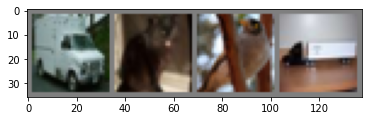

truck   cat  bird truck


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net = net.to(device)

In [5]:
#ReLU
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


net = Net()
net = net.to(device)

In [13]:
#FReLU (funnel activation)

import torch.nn as nn
import torch.nn.functional as F

class FReLU(nn.Module):
    def __init__(self, in_c, k=3, s=1, p=1):
        super().__init__()
        self.f_cond = nn.Conv2d(in_c, in_c, kernel_size=k,stride=s, padding=p,groups=in_c)
        self.bn = nn.BatchNorm2d(in_c)

    def forward(self, x):
        tx = self.bn(self.f_conv(x))
        out = torch.max(x,tx)
        return out

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.frelu = FReLU(6)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.frelu = FReLU(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.frelu = FReLU(120)
        self.fc2 = nn.Linear(120, 84)
        self.frelu = FReLU(84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.frelu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.frelu(x)
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.fc1(x)
        x = self.frelu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


net = Net()
net = net.to(device)

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [12]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

RuntimeError: ignored

In [8]:
#パラメータを保存
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

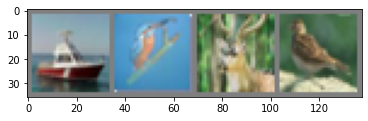

GroundTruth:   ship  bird  deer  bird


In [9]:
#テストについても4つサンプリングする
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [14]:
#保存したパラメータをロードする
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [11]:
outputs = net(images)

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  deer horse  deer


In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [28]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane :  0 %
Accuracy of   car :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse : 98 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %
